In [30]:
import osmnx as ox
import math
from shapely.geometry import Point, LineString, Polygon
from shapely.affinity import rotate
import networkx as nx
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.lib.maps.map import Intersection, Road, RoadString, Node, SubNode


In [33]:
def convert_to_traffic_graph(intersections_inp, roads_inp):
    """

    :param intersections_inp: dict with intersection ID as key and the tuple (x,y) as value
    :param roads_inp: dict with road ID as key and the intersection tuple(id1, id2) as value. Directed road.
    :return: ToDo
    """

    intersections_table = dict.fromkeys(intersections_inp.keys())
    roads_table = dict.fromkeys(roads_inp.keys())
    tg = nx.DiGraph()

    for r_id, r in roads_inp.items():
        if intersections_table[r[0]] is None:
            I = intersections_inp[r[0]]
            intersections_table[r[0]] = Intersection(point_x=I[0], point_y=I[1], osmid=r[0])

        if intersections_table[r[1]] is None:
            I = intersections_inp[r[1]]
            intersections_table[r[1]] = Intersection(point_x=I[0], point_y=I[1], osmid=r[1])

#         print(r_id)
        if roads_table[r_id] is None:
#             print('yes')
            line_string = LineString([intersections_inp[r[0]], intersections_inp[r[1]]])
            road, start_node, end_node = create_road(start_intersection=intersections_table[r[0]],
                                                     end_intersection=intersections_table[r[1]],
                                                     name=None, osmid=r_id, road_string=RoadString(line_string))
            tg.add_node(start_node.get_id(), object=start_node)
            tg.add_node(end_node.get_id(), object=end_node)
            tg.add_edges_from([(start_node.get_id(), end_node.get_id(), {'object': road,
                                                                         'distance': road.get_road_length(),
                                                                         'traffic': None})])

            road, start_node, end_node = create_road(start_intersection=intersections_table[r[0]],
                                                     end_intersection=intersections_table[r[1]],
                                                     name=None, osmid=r_id, road_string=RoadString(line_string))
            tg.add_node(start_node.get_id(), object=start_node)
            tg.add_node(end_node.get_id(), object=end_node)
            tg.add_edges_from([(start_node.get_id(), end_node.get_id(), {'object': road,
                                                                         'distance': road.get_road_length(),
                                                                         'traffic': None})])
            roads_table[r_id] = road

    # Add turn roads, and assign traffic controller to the intersections

    for id_, I in intersections_table.items():

        for i_node in I.get_nodes():
            if i_node.is_incoming():
                iid = i_node.get_id().split("_")[2]
                for o_node in I.get_nodes():
                    if not o_node.is_incoming():
                        oid = o_node.get_id().split("_")[2]
                        if not iid == oid:
                            ls = LineString([(i_node.get_x(), i_node.get_y()), (o_node.get_x(), o_node.get_y())])
                            turn_road = Road(start_node=i_node, end_node=o_node, road_string=RoadString(ls), name='turn',
                                            osmid=i_node.get_id()+str("_")+o_node.get_id())
                            tg.add_edges_from([(i_node.get_id(), o_node.get_id(), {'object': turn_road,
                                                                                   'distance': turn_road.get_road_length(),
                                                                                   'traffic': None})])
                            roads_table[i_node.get_id()+str("_")+o_node.get_id()] = turn_road

    return tg, intersections_table, roads_table


def create_road(start_intersection, end_intersection, name, osmid, road_string):
    """

    :param start_intersection:
    :param end_intersection:
    :param name:
    :param osmid:
    :param road_string:
    :return:
    """

    x1, y1 = start_intersection.get_x(), start_intersection.get_y()
    x2, y2 = end_intersection.get_x(), end_intersection.get_y()

    [p1, p2] = get_node_coords(x1, y1, x2, y2, no_of_lanes=3, lane_width=4)
    # todo: add utils for no of lanes and width

    _id = str(start_intersection.get_osmid()) + "_" + str(osmid) + "_" + str(end_intersection.get_osmid())
    sn1 = Node(point_x=p1[0], point_y=p1[1], incoming=False, parent=start_intersection, _id=_id)
    start_intersection.add_node(sn1)

    _id = str(end_intersection.get_osmid()) + "_" + str(osmid) + "_" + str(start_intersection.get_osmid())
    sn2 = Node(point_x=p2[0], point_y=p2[1], incoming=True, parent=end_intersection, _id=_id)
    end_intersection.add_node(sn2)

    road = Road(start_node=sn1, end_node=sn2, road_string=road_string, name=name, osmid=osmid)

    return road, sn1, sn2


def get_node_coords(x1, y1, x2, y2, no_of_lanes=3, lane_width=4):

    """
    The offset in Point(_ , _) varies if the road is a one way. For now, we only assume two way roads. So each pair of
    intersections has two nodes each along the line joining them, one point each for the one side of the road.
    :param x1:
    :param y1:
    :param x2:
    :param y2:
    :param no_of_lanes:
    :param lane_width:
    :return:
    """
    road_width = no_of_lanes* lane_width
    distance = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    slope = math.atan2(y2 - y1, x2 - x1)
    fs = (0, 0)
    fe = (distance, 0)

    fs2 = Point(10, -road_width/2)

    # fe1 = Point(distance - 10, 0)
    fe2 = Point(distance - 10, -road_width/2)


    os2 = rotate(fs2, angle=slope, origin=fs, use_radians=True)
    oe2 = rotate(fe2, angle=slope, origin=fs, use_radians=True)

    return [(x1 + os2.coords[0][0], y1 + os2.coords[0][1]), (x1 + oe2.coords[0][0], y1 + oe2.coords[0][1])]



In [34]:
import random
intersections_inp = dict()

intersections_inp["i1"] = (50, 0)
intersections_inp["i2"] = (50, 50)
intersections_inp["i3"] = (0, 50)
intersections_inp["i4"] = (150, 0)
intersections_inp["i5"] = (150, 50)
intersections_inp["i6"] = (200, 50)
intersections_inp["i7"] = (0, 150)
intersections_inp["i8"] = (50, 150)
intersections_inp["i9"] = (50, 200)
intersections_inp["i10"] = (150, 200)
intersections_inp["i11"] = (150, 150)
intersections_inp["i12"] = (200, 150)


In [35]:
roads_inp = dict()

roads_inp["i1_r12_i2"] = ("i1","i2")
roads_inp["i2_r12_i1"] = ("i2","i1")

roads_inp["i2_r23_i3"] = ("i2","i3")
roads_inp["i3_r23_i2"] = ("i3","i2")

roads_inp["i4_r45_i5"] = ("i4","i5")
roads_inp["i5_r45_i4"] = ("i5","i4")

roads_inp["i5_r56_i6"] = ("i5","i6")
roads_inp["i6_r56_i5"] = ("i6","i5")

roads_inp["i7_r78_i8"] = ("i7","i8")
roads_inp["i8_r78_i7"] = ("i8","i7")

roads_inp["i8_r89_i9"] = ("i8","i9")
roads_inp["i9_r89_i8"] = ("i9","i8")

roads_inp["i10_r1011_i11"] = ("i10","i11")
roads_inp["i11_r11011_i10"] = ("i11","i10")

roads_inp["i11_r1112_i12"] = ("i11","i12")
roads_inp["i12_r1112_i11"] = ("i12","i11")

roads_inp["i5_r52_i2"] = ("i5","i2")
roads_inp["i2_r52_i5"] = ("i2","i5")

roads_inp["i2_r28_i8"] = ("i2","i8")
roads_inp["i8_r28_i2"] = ("i8","i2")

roads_inp["i8_r811_i11"] = ("i8","i11")
roads_inp["i11_r811_i8"] = ("i11","i8")

roads_inp["i5_r511_i11"] = ("i5","i11")
roads_inp["i11_r511_i5"] = ("i11","i5")


In [36]:
tg, I, R = convert_to_traffic_graph(intersections_inp, roads_inp)

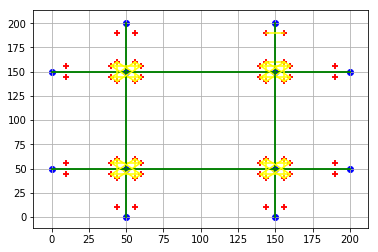

In [37]:
%matplotlib inline
import mpld3
from matplotlib import pyplot as plt

mpld3.enable_notebook()

fig, axis = plt.subplots(1,1)
# print(len(I))
for i, v in I.items():
    axis.scatter(v.get_x(), v.get_y(),marker='o' ,c='blue')
    
    for node in v.get_nodes():
        axis.scatter(node.get_x(), node.get_y(), marker='+', c='red')
        
for edge in tg.edges(data=True):
    road = edge[2]['object']
    if not road.get_name() == 'turn':
#         continue
        road_string = road.get_road_string()
        line_string = road_string.get_line_string()
        x,y = line_string.coords.xy
        axis.plot(x,y, 'green')
    
    else:
        road_string = road.get_road_string()
        line_string = road_string.get_line_string()
        x,y = line_string.coords.xy
        axis.plot(x,y, 'yellow')
        
    
plt.grid()

In [40]:
print(R['i1_r12_i2'].__dict__)

{'_Road__start_node': <core.lib.maps.map.Node object at 0x116dc7e48>, '_Road__end_node': <core.lib.maps.map.Node object at 0x116dc7828>, '_Road__type': 'straight', '_Road__speed_limit': 50, '_Road__road_string': <core.lib.maps.map.RoadString object at 0x10ce17780>, '_Road__lanes': [<core.lib.maps.map.Lane object at 0x116df27b8>, <core.lib.maps.map.Lane object at 0x116df25c0>, <core.lib.maps.map.Lane object at 0x116df2ef0>], '_Road__length': 50.0, '_Road__name': None, '_Road__osmid': 'i1_r12_i2', '_Road__no_of_lanes': 3, '_Road__lane_width': 4}
